<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as tt
from google.colab import drive
from IPython import display
from sklearn.manifold import TSNE
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import seaborn as sns

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!gdown --id 1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x
From (redirected): https://drive.google.com/uc?id=1inyvLrN5wKBGCxQ4znMKBc64uL4uP_2x&confirm=t&uuid=25f5ddbd-7ec4-4b90-986c-2315a0da2a5f
To: /content/archive.zip
100% 4.28G/4.28G [00:40<00:00, 106MB/s] 


In [ ]:
!unzip -q 'archive.zip'

In [ ]:
!mkdir '/content/faces/'

In [ ]:
!mv '/content/faces_dataset_small' '/content/faces'

In [ ]:
train_dataset = ImageFolder(
    "/content/faces/",
    transform=tt.Compose(
        [tt.Resize(128), tt.CenterCrop(128), tt.ToTensor(), tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    ),
)

In [ ]:
def denormalize(tensors, mean, std):
    return tensors * std + mean

In [ ]:
def show_images(images, nrows=8, ncols=8):
    images = denormalize(images.detach().cpu()[: nrows * ncols], 0.5, 0.5)

    fig, ax = plt.subplots(figsize=(nrows, ncols))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrows).permute(1, 2, 0))

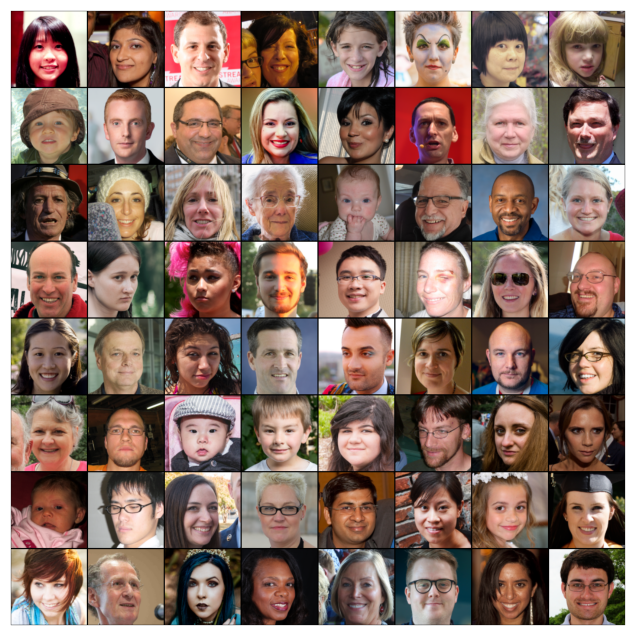

In [ ]:
images = torch.stack([train_dataset[i][0] for i in range(64)])
show_images(images)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.discriminator(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.generator(x)

In [ ]:
class GAN(nn.Module):
    def __init__(self, latent_size):
        super().__init__()

        self.latent_size = latent_size
        self.discriminator = Discriminator()
        self.generator = Generator(latent_size)

    def forward(self, x):
        return self.generator(x)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
def train(
    model,
    criterions,
    train_dataset,
    num_epochs,
    batch_size,
    lr=2e-4,
    scheduler=False,
    step_size=(1, 1),
    gammas=(0.1, 0.1),
):
    model.train()

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2)

    optimizers = {
        "discriminator": optim.Adam(model.discriminator.parameters(), lr=lr, betas=(0.5, 0.999)),
        "generator": optim.Adam(model.generator.parameters(), lr=lr, betas=(0.5, 0.999)),
    }

    if scheduler:
        schedulers = {
            "discriminator": lr_scheduler.StepLR(optimizers["discriminator"], step_size[0], gammas[0]),
            "generator": lr_scheduler.StepLR(optimizers["discriminator"], step_size[1], gammas[1]),
        }

    d_loss = []
    g_loss = []

    fake_score = []
    real_score = []

    output_display = display.display("Collecting data for plot...", display_id=True)
    fig, (loss_ax, score_ax) = plt.subplots(1, 2, figsize=(15, 8))

    for epoch in tqdm(range(num_epochs), desc="epoch"):

        d_epoch_loss = 0
        g_epoch_loss = 0

        fake_epoch_score = 0
        real_epoch_score = 0

        for real_images, _ in tqdm(train_loader, desc="batch"):
            real_images = real_images.to(device)

            optimizers["discriminator"].zero_grad()

            latent = torch.randn((real_images.shape[0], model.latent_size, 1, 1), device=device)
            fake_images = model.generator(latent)

            real_preds = model.discriminator(real_images)
            fake_preds = model.discriminator(fake_images)

            real_batch_loss = criterions["discriminator"](
                real_preds, torch.ones((real_images.shape[0], 1), device=device)
            )
            fake_batch_loss = criterions["discriminator"](
                fake_preds, torch.zeros((real_images.shape[0], 1), device=device)
            )

            d_batch_loss = real_batch_loss + fake_batch_loss
            d_batch_loss.backward()
            optimizers["discriminator"].step()

            fake_epoch_score += fake_preds.mean().item()
            real_epoch_score += real_preds.mean().item()

            d_epoch_loss += d_batch_loss.item()

            optimizers["generator"].zero_grad()

            latent = torch.randn((real_images.shape[0], model.latent_size, 1, 1), device=device)
            fake_images = model.generator(latent)

            fake_preds = model.discriminator(fake_images)

            g_batch_loss = criterions["generator"](fake_preds, torch.ones((fake_images.shape[0], 1), device=device))
            g_batch_loss.backward()
            optimizers["generator"].step()

            g_epoch_loss += g_batch_loss.item()

        d_epoch_loss /= len(train_loader)
        g_epoch_loss /= len(train_loader)

        fake_epoch_score /= len(train_loader)
        real_epoch_score /= len(train_loader)

        print(
            f"d_loss: {d_epoch_loss} g_loss: {g_epoch_loss} real_score: {real_epoch_score} fake_score: {fake_epoch_score}"
        )

        d_loss.append(d_epoch_loss)
        g_loss.append(g_epoch_loss)

        fake_score.append(fake_epoch_score)
        real_score.append(real_epoch_score)

        if scheduler:
            schedulers["discriminator"].step()
            schedulers["generator"].step()

        loss_ax.clear()
        score_ax.clear()

        loss_ax.plot(d_loss, label="discriminator")
        loss_ax.plot(g_loss, label="generator")
        loss_ax.set_xlim(0, num_epochs)
        loss_ax.set_ylim(0)
        loss_ax.set_xlabel("epoch")
        loss_ax.set_ylabel("loss")
        loss_ax.legend()

        score_ax.plot(fake_score, label="fake")
        score_ax.plot(real_score, label="real")
        score_ax.set_xlim(0, num_epochs)
        score_ax.set_ylim(-0.1, 1.1)
        score_ax.set_xlabel("epoch")
        score_ax.set_ylabel("score")
        score_ax.legend()

        if epoch > 1:
            output_display.update(fig)

    plt.close(fig)

    return d_loss, g_loss, real_score, fake_score

In [ ]:
latent_size = 128
gan = GAN(latent_size).to(device)
criterions = {"discriminator": nn.BCELoss(), "generator": nn.BCELoss()}

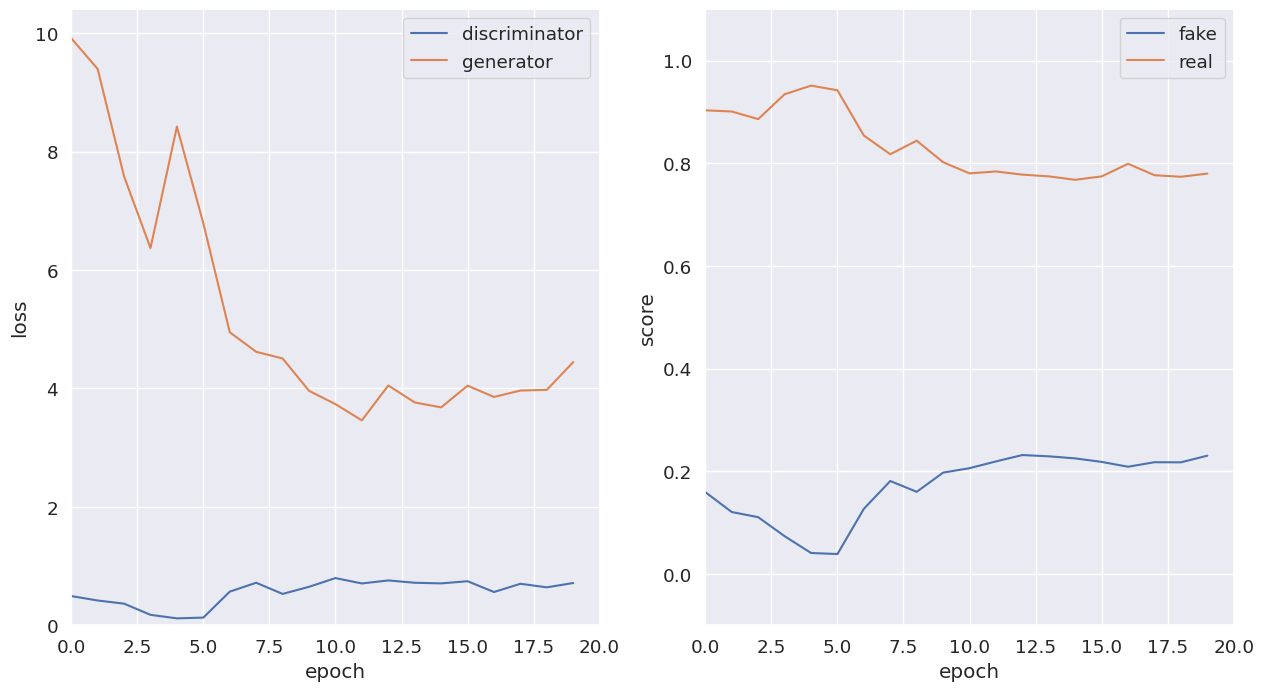

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

batch:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


d_loss: 0.4926044239103794 g_loss: 9.912714233398438 real_score: 0.9031528961658478 fake_score: 0.15929071684273027


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.4180565439537168 g_loss: 9.393978605270386 real_score: 0.900803679227829 fake_score: 0.1205808021959433


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.3646066890284419 g_loss: 7.578386697769165 real_score: 0.8859874606132507 fake_score: 0.11053736979860332


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.1759115718305111 g_loss: 6.369832262992859 real_score: 0.934373049736023 fake_score: 0.07350663487537532


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.11644276512786746 g_loss: 8.420377731323242 real_score: 0.9512447071075439 fake_score: 0.04078734412451354


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.1293114822730422 g_loss: 6.785543513298035 real_score: 0.9421571981906891 fake_score: 0.03869405833695055


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.5677501063793897 g_loss: 4.947836328744888 real_score: 0.8539876334369183 fake_score: 0.1268409722135766


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7177480064332485 g_loss: 4.617399698095396 real_score: 0.8175668896734715 fake_score: 0.18100433174869976


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.529248153269291 g_loss: 4.5047276186943055 real_score: 0.8439795276522637 fake_score: 0.1599215930403443


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.6493543264269829 g_loss: 3.959124701023102 real_score: 0.8020645141601562 fake_score: 0.1973651877976954


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7964936885237693 g_loss: 3.7340968745946883 real_score: 0.7802529672719538 fake_score: 0.20599834850116167


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7056535530090332 g_loss: 3.4600761580467223 real_score: 0.7840051861666143 fake_score: 0.2191442965203896


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7569644591212272 g_loss: 4.049293467998504 real_score: 0.7777987715601921 fake_score: 0.23158280498348177


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7174129807949066 g_loss: 3.7624408650398253 real_score: 0.7744340914487838 fake_score: 0.2291008490533568


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7069975692033768 g_loss: 3.6792313122749327 real_score: 0.7677513754367828 fake_score: 0.22502788663608952


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7436644664406776 g_loss: 4.045748553276062 real_score: 0.7743931929022074 fake_score: 0.21821454313467256


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.5612088948488235 g_loss: 3.855244002342224 real_score: 0.7989678311347962 fake_score: 0.20880917189177126


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7004155850410462 g_loss: 3.9635462594032287 real_score: 0.7767037779092789 fake_score: 0.21760163127677515


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.6402443820238113 g_loss: 3.9750949895381926 real_score: 0.773647353053093 fake_score: 0.21740151952952147


batch:   0%|          | 0/50 [00:00<?, ?it/s]

d_loss: 0.7134579551219941 g_loss: 4.44411634683609 real_score: 0.7798887020349503 fake_score: 0.23034098099684341


In [ ]:
d_loss, g_loss, real_score, fake_score = train(gan, criterions, train_dataset, 20, 64)

In [ ]:
torch.save(gan.state_dict(), "/content/gan.pt")

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
def show(images, nrows=8, ncols=8):
    images = denormalize(images.detach().cpu()[: nrows * ncols], 0.5, 0.5)

    fig, ax = plt.subplots(figsize=(nrows, ncols))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrows).permute(1, 2, 0))

In [ ]:
def show_from(model, n_images=16):
  fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
  fake_images = model.generator(fixed_latent)
  show(fake_images, 4, 4)

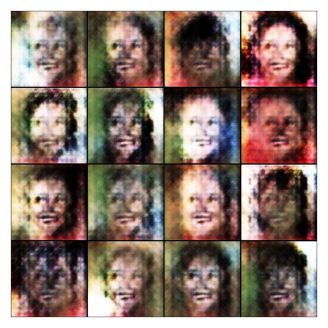

In [ ]:
show_from(gan)

Как вам качество получившихся изображений?

Картинки будто похожи между собой, но тем не менее, на человеческие лица они похожи. Скорее всего, требуется больше эпох обучения, но в целом, неплохой результат

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
latent = torch.randn((len(train_dataset), latent_size, 1, 1)).to(device)
with torch.no_grad():
    fake_images = denormalize(gan(latent).detach().cpu(), 0.5, 0.5).permute(0, 2, 3, 1)

real_images = next(iter(DataLoader(train_dataset, len(train_dataset))))[0].permute(0, 2, 3, 1)

In [ ]:
train_images = torch.cat((fake_images, real_images))
train_labels = torch.cat(
    (
        torch.zeros(
            fake_images.shape[0],
        ),
        torch.ones(real_images.shape[0]),
    )
)

perm_idxs = torch.randperm(train_images.shape[0])

train_images = train_images[perm_idxs].reshape(train_images.shape[0], -1)
train_labels = train_labels[perm_idxs].reshape(
    train_labels.shape[0],
)

In [ ]:
loo = LeaveOneOut()

real_acc = 0
fake_acc = 0
mean_acc = 0

real_n = 0
fake_n = 0

for train_index, test_index in tqdm(
    loo.split(train_images), total=loo.get_n_splits(train_images), leave=False, desc="n"
):
    X_train, X_test = train_images[train_index], train_images[test_index]
    y_train, y_test = train_labels[train_index], train_labels[test_index]

    classifier = KNeighborsClassifier(1)
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict_proba(X_test)[0]

    if y_test:
        real_acc += y_pred[1]
        real_n += 1
    else:
        fake_acc += y_pred[0]
        fake_n += 1

    mean_acc += classifier.score(X_test, y_test)

real_acc /= real_n
fake_acc /= fake_n
mean_acc /= train_images.shape[0]

In [ ]:
print(f"real_acc: {real_acc}, fake_acc: {fake_acc}, mean_acc: {mean_acc}")

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Мы бы хотели получить accuracy 0.5, это бы значило, что дискриминатор не может отличить сгенерированные генератором изображения от настоящих (чего и нужно добиться)

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
images_repr = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(train_images[:2000])
real_repr = images_repr[train_labels[:2000].numpy().astype(bool)]
fake_repr = images_repr[(1 - train_labels[:2000].numpy()).astype(bool)]

Прокомментируйте получившийся результат:

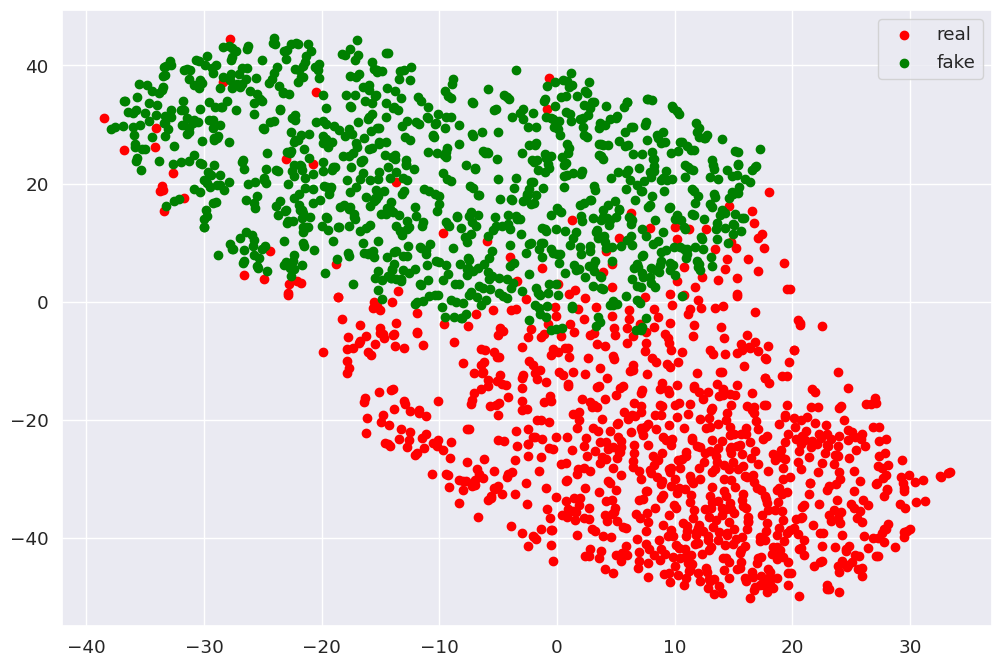

In [ ]:
plt.figure(figsize=(12, 8))
colors = ["green", "red"]
plt.scatter(real_repr[:, 0], real_repr[:, 1], c="red", label="real")
plt.scatter(fake_repr[:, 0], fake_repr[:, 1], c="green", label="fake")
plt.legend()
plt.show()

Изображения хорошо классифицируемы, в лучшем случае такого быть не должно, как было описано выше, мы должны стремиться к accuracy=0.5. Также можно заметить, что некоторые точки реальный изображений лежат классифицируются как фейковые